### explore data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

xdata = pd.read_csv("./Data/YMdata.csv", header=None, usecols = range(0, 22))
ydata = pd.read_csv("./Data/YMdata.csv", header=None, usecols = range(22, 23))
#xdata.head()

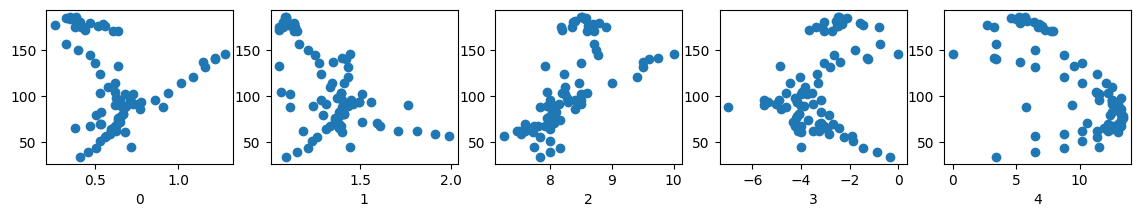

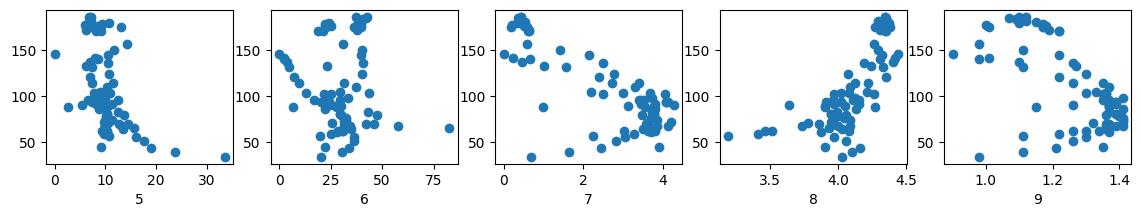

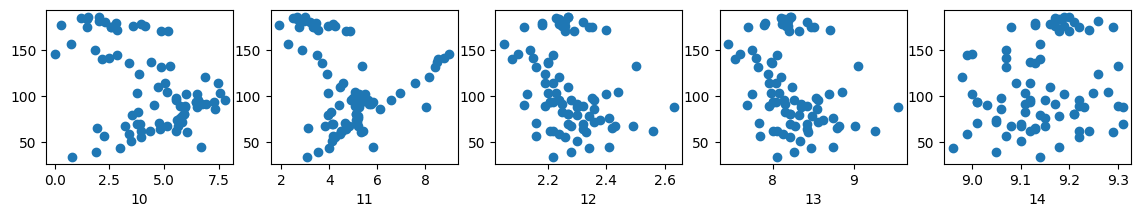

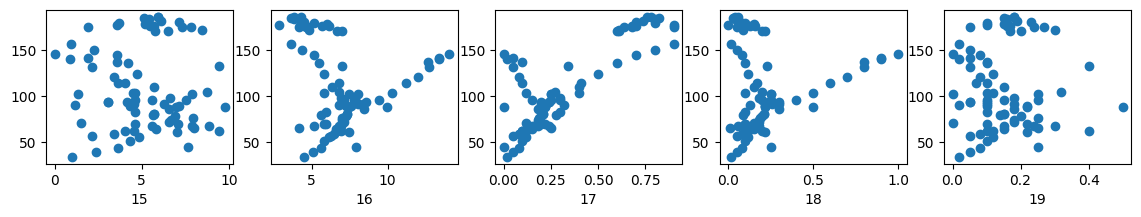

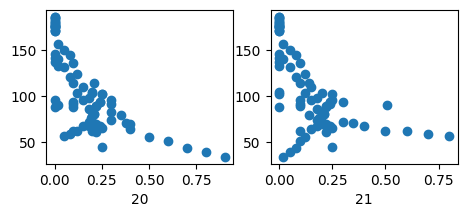

In [2]:
# visualize the data
m = 0
for i in range(4):
    plt.figure(figsize=(14,2))
    for j in range(1, 6):
        plt.subplot(1, 5, j)
        plt.scatter(xdata[m], ydata)
        plt.xlabel(m)
        m += 1

plt.figure(figsize=(14,2))
for i in range(1, 3):
    plt.subplot(1, 5, i)
    plt.scatter(xdata[m], ydata)
    plt.xlabel(m)
    m += 1

#### columns 14 and 15 looks have no relation with YM
we will remove columns 14 and 15

In [ ]:
xydata = pd.read_csv("./Data/YMdata.csv", header=None)
xydata.shape

xydata = xydata.drop(xdata.columns[[14, 15]], axis=1)
np.savetxt("./Data/selected_YMdata.csv", xydata, delimiter = ",")

### Prepare data for PyTorch

In [1]:
import torch
import torch.utils.data as td
from sklearn.model_selection import train_test_split
import pandas as pd

def loaddata(pathway, support_list, batchsize):
    df = pd.read_csv(pathway, header=None)
    x = df.iloc[:, 0:20].values
    y = df.iloc[:, 20].values

    x_support = df.iloc[support_list, 0:20].values
    y_support = df.iloc[support_list, 20].values
   
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)
    
    # create loader for the training data and labels
    train_x = torch.Tensor(x_train).float()
    train_x = train_x.reshape(72, 1, 20).float()
    train_y = torch.Tensor(y_train).float()

    train_data = td.TensorDataset(train_x, train_y)
    train_loader = td.DataLoader(train_data, batch_size=batchsize, shuffle=False, num_workers=1)

    # create loader for the testing data and labels
    test_x = torch.Tensor(x_test).float()
    test_x = test_x.reshape(8, 1, 20).float()
    test_y = torch.Tensor(y_test).float()

    test_data = td.TensorDataset(test_x, test_y)
    test_loader = td.DataLoader(test_data, batch_size=batchsize, shuffle=False, num_workers=1)

    # create loader for the support data and labels
    support_x = torch.Tensor(x_support).float()
    support_x = support_x.reshape(len(support_list), 1, 20).float()
    support_y = torch.Tensor(y_support).float()

    support_data = td.TensorDataset(support_x, support_y)
    support_loader = td.DataLoader(support_data, batch_size=1, shuffle=False, num_workers=1)

    return train_loader, test_loader, support_loader


pathway = './Data/selected_YMdata.csv'
support_list = [0, 8, 17, 30, 49]
batchsize = 1

train_loader, test_loader, support_loader = loaddata(pathway, support_list, batchsize)

for x, y in train_loader:
    pass

print(x.shape)

torch.Size([1, 1, 20])


### Build training model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CNNmodel(nn.Module):
    def __init__(self, inputs_num):
        super(CNNmodel, self).__init__()
        self.inputs_num = inputs_num
        self.conv0 = nn.Conv1d(2, 32, 1)
        self.conv1 = nn.Conv1d(32, 32, 1)
        self.conv2 = nn.Conv1d(32, 32, 1)
        self.conv3 = nn.Conv1d(32, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten
        x = x.view(-1, self.inputs_num)
        return x

class DNNmodel(nn.Module):
    def __init__(self, outputs_num):
        super(DNNmodel, self).__init__()
        self.outputs_num = outputs_num
        self.fc0 = nn.Linear(outputs_num, 32)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class FSLmodel(nn.Module):
    def __init__(self, inputs_num, x1, x2, x3, x4, x5):
        super(FSLmodel, self).__init__()
        self.x1, self.x2, self.x3, self.x4, self.x5 = x1, x2, x3, x4, x5
        self.outputs_num = inputs_num * 5
        self.Cnet = CNNmodel(inputs_num)
        self.Dnet = DNNmodel(self.outputs_num)
        
    def forward(self, x):
        batchsize = x.shape[0]
        out1 = self.Cnet(torch.cat([x, self.x1.repeat(batchsize, 1, 1)], dim=1))
        out2 = self.Cnet(torch.cat([x, self.x2.repeat(batchsize, 1, 1)], dim=1))
        out3 = self.Cnet(torch.cat([x, self.x3.repeat(batchsize, 1, 1)], dim=1))
        out4 = self.Cnet(torch.cat([x, self.x4.repeat(batchsize, 1, 1)], dim=1))
        out5 = self.Cnet(torch.cat([x, self.x5.repeat(batchsize, 1, 1)], dim=1))

        out = torch.cat([out1, out2, out3, out4, out5], dim=1)
        outputs = self.Dnet(out)
        return outputs


### Train the model

In [3]:
def train(model, train_loader, optimizer):
    # set model to train mode
    model.train()
    train_loss, train_error = 0, 0

    index = 0
    for data, target in train_loader:
        # feed forward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        error = error_criteria(out, target)
        
        # backpropagate
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_error += error.item()
        index += 1

    avg_loss, avg_error = (train_loss / index), (train_error / index)
    print("Training set: Average loss: {:.6f}, error: {:.6f}".format(avg_loss, avg_error))
    return avg_loss, avg_error

def test(model, test_loader):
    # set the model to test
    model.eval()
    test_loss, error_loss = 0, 0

    with torch.no_grad():
        index = 0
        for data, target in test_loader:
            out = model(data)
            loss = loss_criteria(out, target)
            error = error_criteria(out, target)

            test_loss += loss.item()
            error_loss += error.item()
            index += 1

        avg_loss, avg_error = test_loss / index, error_loss / index
        print("Test set: Average loss: {:.6f}, error: {:.6f}".format(avg_loss, avg_error))
        return avg_loss, avg_error



#### Train the model

In [5]:
import torch.nn as nn

# specify the loss criteria
class MyError(nn.Module):
    def __init__(self):
        super(MyError, self).__init__()

    def forward(self, pred, real):
        return torch.mean(torch.abs(torch.sub(pred, real) / real))

error_criteria = MyError()
loss_criteria = nn.MSELoss(reduction="mean")

pathway = './Data/selected_YMdata.csv'
support_list = [0, 8, 17, 30, 49]
batchsize = 1

train_loader, test_loader, support_loader = loaddata(pathway, support_list, batchsize)

sx = []
for supportx, supporty in support_loader:
    sx.append(supportx)


x1, x2, x3, x4, x5 = sx[0], sx[1], sx[2], sx[3], sx[4]
inputs_num = 20
model = FSLmodel(inputs_num, x1, x2, x3, x4, x5)

# use "Adam"
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer.zero_grad()

# track meterics
epoch_nums = []
training_loss, training_error = [], []
testing_loss, testing_error = [], []

epochs = 100
for epoch in range(1, epochs+1):
    print("Epoch: {}".format(epoch))

    train_loss, train_error = train(model, train_loader, optimizer)
    test_loss, test_error = test(model, test_loader)

    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_error.append(train_error)

    testing_loss.append(test_loss)
    testing_error.append(test_error)

Epoch: 1


C:\Users\lpwu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training set: Average loss: 13911.088696, error: 0.993880
Test set: Average loss: 11717.866882, error: 0.987304
Epoch: 2
Training set: Average loss: 13302.556689, error: 0.962778
Test set: Average loss: 10610.585999, error: 0.933496
Epoch: 3
Training set: Average loss: 11263.817574, error: 0.850589
Test set: Average loss: 7690.611267, error: 0.774924
Epoch: 4
Training set: Average loss: 7480.995814, error: 0.608245
Test set: Average loss: 3758.586197, error: 0.492439
Epoch: 5
Training set: Average loss: 3933.922755, error: 0.383359
Test set: Average loss: 1363.806796, error: 0.192497
Epoch: 6
Training set: Average loss: 2413.733923, error: 0.378322
Test set: Average loss: 807.608907, error: 0.139761
Epoch: 7
Training set: Average loss: 2136.800163, error: 0.424957
Test set: Average loss: 768.306082, error: 0.169307
Epoch: 8
Training set: Average loss: 2113.282540, error: 0.445942
Test set: Average loss: 773.788355, error: 0.181787
Epoch: 9
Training set: Average loss: 2112.793314, error

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, testing_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'test'], loc='upper right')
plt.show()

plt.savefig("./Models/YM_loss.png")

#### save the trained model

In [ ]:
model_file = "./Models/HEA_YM.pt"
torch.save(model.state_dict(), model_file)
del model
print("model is saved")